In [ ]:
## Using Common Spatial Patterns to Highlight Changes Between Meditators and Controls
# Utsav Dutta
# MILE Lab, IISc Bangalore

'''
    EEG data is first loaded as raw numpy files.
    Electrode coordinates are loaded for spatial locations. These are used to compute the surface laplacian filter.
'''

In [1]:
cd D:\files

D:\files


In [2]:
import readmat
from mat4py import loadmat
import os
import numpy as np
import mat4py
#from scipy.io import loadmat
import pandas as pd
import matplotlib.pyplot as plt
from scipy import signal
from matplotlib.pyplot import specgram
from scipy.fft import fft, ifft

C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\numpy\_distributor_init.py:32: UserWarning: loaded more than 1 DLL from .libs:
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.PYQHXLVVQ7VESDPUVUADXEVJOBGHJPAY.gfortran-win_amd64.dll
C:\Users\Utsav Dutta\Anaconda3\lib\site-packages\numpy\.libs\libopenblas.TXA6YQSD3GCQQC22GEQ54J2UDCXDXHWN.gfortran-win_amd64.dll
  stacklevel=1)


In [3]:
parent_directory = 'D:/files'

In [5]:
# 3 electrodes were missing from some data points, we remove them from the data for all subjects
missing_electrodes = ['FC2','Cz','Pz']

In [6]:
# Create dictionary of EEG_data
EEG_data = {}

# Scan each subject
try:
    
    # Iterate through directories using listdir
    for i in os.listdir(parent_directory):

        for j in os.listdir(os.path.join(parent_directory,i)):
            
            # Consider files ending with the required .mat extension, and only consider baseline data
            if j[-3:] == 'mat' and j[-6:-4] == 'BL':

                # Print for reference
                print(j)
                
                # Use external library to load native matlab files
                dat = readmat.mat2dict(os.path.join(os.path.join(parent_directory,i),j))
                
                # Labels are electrode names, stored in EEG files as 'chanlocs'
                labels = [item['labels'] for item in dat['EEG']['chanlocs']]
                
                # Load the EEG data, intervals are taken every 8th timestamp
                # New sampling rate = (1/8)*OriginalSamplingRate
                # 1024*(1/8) = 128Hz
                
                EEG_signal = np.matrix(dat['EEG']['data'])[:,::8]
                
                # Create dataframe object with signal and labels
                EEG_signal = pd.DataFrame(EEG_signal,index = labels)
                
                # Append to dictionary, remove the rows containing any of the missing electrodes
                EEG_data[j[:4],j[-6:-4]] = EEG_signal[~EEG_signal.index.isin(missing_electrodes)]

except: 

    pass

001ABI190116BL.mat
002ANI190116BL.mat
006BIR160116BL.mat
008DEE190116BL.mat
009DEV200120BL.mat
015GUR170116BL.mat
016HEM180116BL.mat
017HIT190116BL.mat
018KIS160116BL.mat
020NAR170116BL.mat
023RAN190116BL.mat
024SAN200116BL.mat
025SAN200116BL.mat
026STE170116BL.mat
C001ANA191116BL.mat
C002PAN171116BL.mat
C003IND310316BL.mat
C004MAN211116BL.mat
C005PRA310316BL.mat
C006RAJ221116BL.mat


In [7]:
# Helper function to compute surface laplacian to apply spatial filtering
# https://www.sciencedirect.com/science/article/abs/pii/S0167876015001749

def surface_laplacian(EEG_signal,x,y,z):
    
    numelectrodes = len(x)
    def cart2sph(x, y, z):
            hxy = np.hypot(x, y)
            r = np.hypot(hxy, z)
            el = np.arctan2(z, hxy)
            az = np.arctan2(y, x)
            return az, el, r
    junk1, junk2, spherical_radii = cart2sph(x,y,z)
    maxrad = np.max(spherical_radii)
    x = x/maxrad
    y = y/maxrad
    z = z/maxrad
    cosdist = np.zeros((numelectrodes, numelectrodes))
    for i in range(numelectrodes):
        for j in range(i+1,numelectrodes):
            cosdist[i,j] = 1 - (((x[i] - x[j])**2 + (y[i] - y[j])**2 + (z[i] - z[j])**2)/2)

    cosdist = cosdist + cosdist.T + np.identity(numelectrodes)
    leg_order = 10
    from scipy import special
    legpoly = np.zeros((leg_order, numelectrodes, numelectrodes))
    for ni in range(leg_order):
        for i in range(numelectrodes):
            for j in range(i+1, numelectrodes):
                #temp = special.lpn(8,cosdist[0,1])[0][8]
                legpoly[ni,i,j] = special.lpn(ni+1,cosdist[i,j])[0][ni+1]
    for i in range(leg_order):
        legpoly[i,:,:] = legpoly[i,:,:] + np.identity(numelectrodes)
    m = 4
    import math
    twoN1 = np.multiply(2, range(1, leg_order+1))+1
    gdenom = np.power(np.multiply(range(1, leg_order+1), range(2, leg_order+2)), m, dtype=float)
    hdenom = np.power(np.multiply(range(1, leg_order+1), range(2, leg_order+2)), m-1, dtype=float)

    G = np.zeros((numelectrodes, numelectrodes))
    H = np.zeros((numelectrodes, numelectrodes))

    for i in range(numelectrodes):
        for j in range(i, numelectrodes):

            g = 0
            h = 0

            for ni in range(leg_order):
                g = g + (twoN1[ni] * legpoly[ni,i,j]) / gdenom[ni]
                h = h - (twoN1[ni] * legpoly[ni,i,j]) / hdenom[ni]

            G[i,j] = g / (4*math.pi)
            H[i,j] = -h / (4*math.pi)

    G = G + G.T
    H = H + H.T

    G = G - np.identity(numelectrodes) * G[1,1] / 2
    H = H - np.identity(numelectrodes) * H[1,1] / 2
    smoothing = 1e-5
    orig_data_size = np.squeeze(EEG_signal.shape)
    if np.any(orig_data_size==1):
        EEG_signal = EEG_signal[:]
    else:
        EEG_signal = np.reshape(EEG_signal, (orig_data_size[0], np.prod(orig_data_size[1:3])))
    Gs = G + np.identity(numelectrodes) * smoothing
    GsinvS = np.sum(np.linalg.inv(Gs), 0)
    dataGs = np.dot(EEG_signal.T, np.linalg.inv(Gs))

    C = dataGs - np.dot(np.atleast_2d(np.sum(dataGs, 1)/np.sum(GsinvS)), np.atleast_2d(GsinvS))
    surf_lap = np.reshape(np.transpose(np.dot(C,np.transpose(H))), orig_data_size)

    return surf_lap

In [9]:
# Dictionary of electrode coordinates in 3d space. Stored in EEGDict structure
electrode_coordinates = {}

# Iterate through data files
try:

    for i in os.listdir(parent_directory):

            for (index,j) in enumerate(os.listdir(os.path.join(parent_directory,i))):

                if j[-3:] == 'mat' and index == 0:

                    dat = readmat.mat2dict(os.path.join(os.path.join(parent_directory,i),j))
                    
                    # The coordinates are stored as a tuple in chanlocs indexed as ['X','Y','Z']
                    x = [item['X'] for item in dat['EEG']['chanlocs']]
                    y = [item['Y'] for item in dat['EEG']['chanlocs']]
                    z = [item['Z'] for item in dat['EEG']['chanlocs']]
                    labels = [item['labels'] for item in dat['EEG']['chanlocs']]
                    
                    # Create a similar dataframe with all requisite electrodes and their locations
                    electrode_coordinates[j[:4]] = pd.DataFrame(np.vstack([x,y,z]).T,labels)
                    print(j)

except:
    
    pass

001ABI190116AN.mat
002ANI190116AN.mat
006BIR160116AN.mat
008DEE190116AN.mat
009DEV200120AN.mat
015GUR170116AN.mat
016HEM180116AN.mat
017HIT190116AN.mat
018KIS160116AN.mat
020NAR170116AN.mat
023RAN190116AN.mat
024SAN200116AN.mat
025SAN200116AN.mat
026STE170116AN.mat
C001ANA191116BL.mat
C002PAN171116BL.mat
C003IND310316BL.mat
C004MAN211116BL.mat
C005PRA310316BL.mat
C006RAJ221116BL.mat


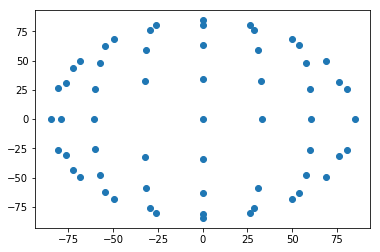

In [106]:
# Visualizing 2d locations of electrodes for one subject. 
# Note: Laplacian function can be used for 2D as well, this study uses 3D data.

plt.scatter(electrode_coordinates['001A'][0],electrode_coordinates['001A'][1])

In [10]:
# Convert EEGData -> EEGData Laplacian

missing_electrodes = ['FC2','Cz','Pz']
EEG_laplacian = {}

# Iterate over each subject
try:

    for i in os.listdir(parent_directory):

        for j in os.listdir(os.path.join(parent_directory,i)):
            
            # Again, filter out only baseline data as we wont consider other states
            if j[-3:] == 'mat' and j[-6:-4] == 'BL':
                
                # Extract data from matlab file
                dat = readmat.mat2dict(os.path.join(os.path.join(parent_directory,i),j))

                # Extract channel info present in this sample using the electrodes dict created above
                electrodes = electrode_coordinates[j[:4]]
                
                # Find missing electrodes and remove
                idx = pd.to_numeric(electrodes[0],errors='coerce').isna()

                electrodes = electrodes[~idx]
                
                # Load electrode coordinates as np.float objects
                x = electrodes.iloc[:,0]
                y = electrodes.iloc[:,1]
                z = electrodes.iloc[:,2]

                x = x.astype(float)
                y = y.astype(float)
                z = z.astype(float)


                # Similar to earlier data loading process. Downsample to 128Hz
                EEG_signal = np.matrix(dat['EEG']['data']).astype(np.float32)[:,::8]
                
                # Drop missing electrodes
                EEG_signal = np.delete(EEG_signal,np.where(idx),axis = 0)

                df = pd.DataFrame(EEG_signal,index = electrodes.index)
                
                # Implement surface Laplacian
                lap = surface_laplacian(np.matrix(df.values),x,y,z)
                
                # Save laplacian as a dataframe
                df = pd.DataFrame(lap,electrodes.index)
                
                # Store result in a new EEGLaplacian dictionary
                EEG_laplacian[j[:4],j[-6:-4]] = df[~df.index.isin(missing_electrodes)]
                
                # Print subject
                print(j)
                
except:
    
    pass

001ABI190116BL.mat
002ANI190116BL.mat
006BIR160116BL.mat
008DEE190116BL.mat
009DEV200120BL.mat
015GUR170116BL.mat
016HEM180116BL.mat
017HIT190116BL.mat
018KIS160116BL.mat
020NAR170116BL.mat
023RAN190116BL.mat
024SAN200116BL.mat
025SAN200116BL.mat
026STE170116BL.mat
C001ANA191116BL.mat
C002PAN171116BL.mat
C003IND310316BL.mat
C004MAN211116BL.mat
C005PRA310316BL.mat
C006RAJ221116BL.mat


In [ ]:
# Now we have an EEG dict and EEGLaplacian dict containing the EEG data as a raw and spatially filtered form respectively.

# Create epochs of EEG data. Each epoch is 10 seconds long. 10 seconds => 10*128 samples
# Define a helper function which takes the data and epoch length as arguments

def create_epochs(EEG_data,n_seconds = 10):
    
    # Create an epoched data dictionary 
    
    EEG_data_epoched = {}
    
    # Specify epoch length, set to 10 seconds by defauly
    epoch_length = 128*n_seconds
    
    # Iterate through the data dict
    for subject in EEG_data:
        
      # Temporary list to collect epoched data
      arr = []
        
      # Iterate over data and slice using numpy's iloc function.
      for start in range(0,EEG_data[subject].shape[1],epoch_length):  

        if start + epoch_length < EEG_data[subject].shape[1]:
          arr.append(EEG_data[subject].iloc[:,start:start+epoch_length].values)
      
      # Convert list to np.array
      arr = np.array(arr)
      
      # Append to EEGEpoched dict
      EEG_data_epoched[subject] = arr
    
    return EEG_data_epoched

# Apply function, returns the epoched dictionaries stored as 2 new variables

EEG_data_epoched = create_epochs(EEG_data,10)
EEG_laplacian_epoched = create_epochs(EEG_data_laplacian,10)

## Common Spatial Patterns

In [48]:
## Implementation of Common Spatial Patterns
# Refer: https://www.sciencedirect.com/topics/engineering/common-spatial-pattern, Introduction, Section1.1

# Create placeholder matrix for average covariance for both classes, meditators and controls

S_controls = np.zeros([58,58])
S_meditators = np.zeros([58,58])

# Create counter variables
controls = 0 
meditators = 0

# Loop through each subject and append the covariance matrix
for subject in EEG_data:
    
    # Control subjects start with the letter 'C' in subject ID. Filter by string.
    
    # For controls
    if subject[0][0] == 'C':
        
        # Append the covariance matrix, normalize by the trace. Refer to article for details.
        S_controls += np.dot(EEG_data[subject],EEG_data[subject].T)/np.dot(EEG_data[subject],EEG_data[subject].T).trace()
        controls = controls + 1
    
    # For meditators
    else:

        S_meditators += np.dot(EEG_data[subject],EEG_data[subject].T)/np.dot(EEG_data[subject],EEG_data[subject].T).trace()
        meditators = meditators + 1

# Take mean over samples
S_controls = S_controls/controls
S_meditators = S_meditators/meditators

In [50]:
import scipy.linalg as la

# Compute matrix that maximizes classwise variance
W = la.eig(np.dot(np.linalg.inv(S_meditators),S_controls))[1]

0


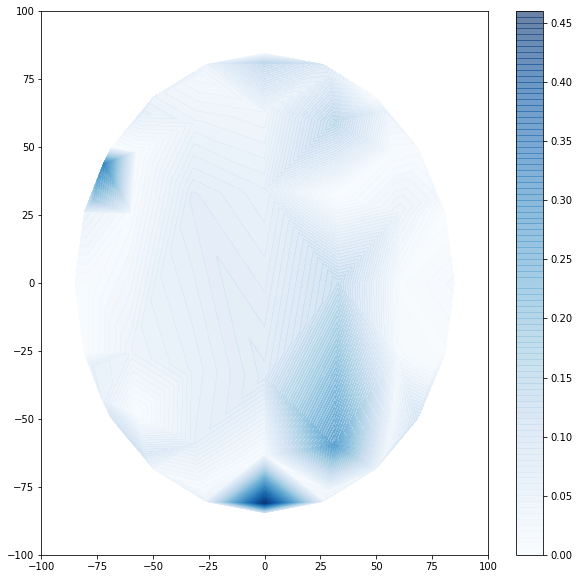

1


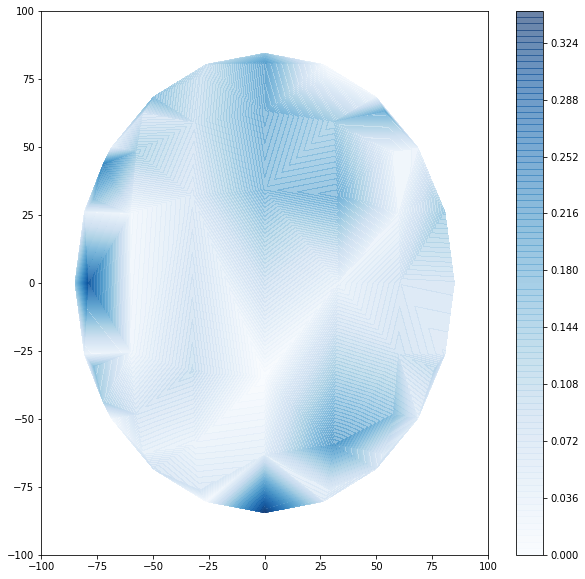

2


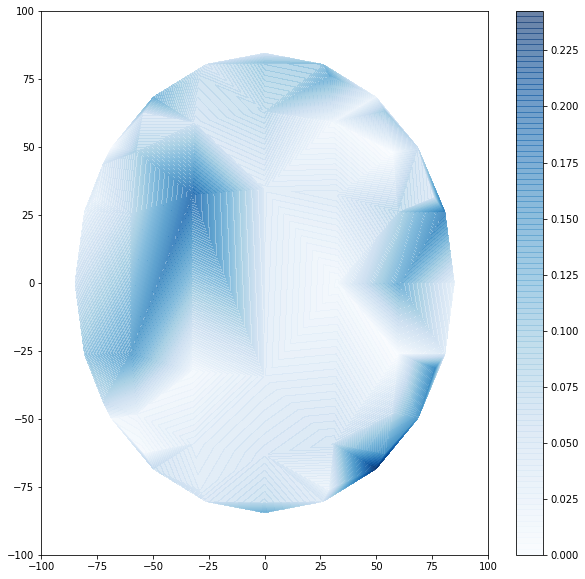

3


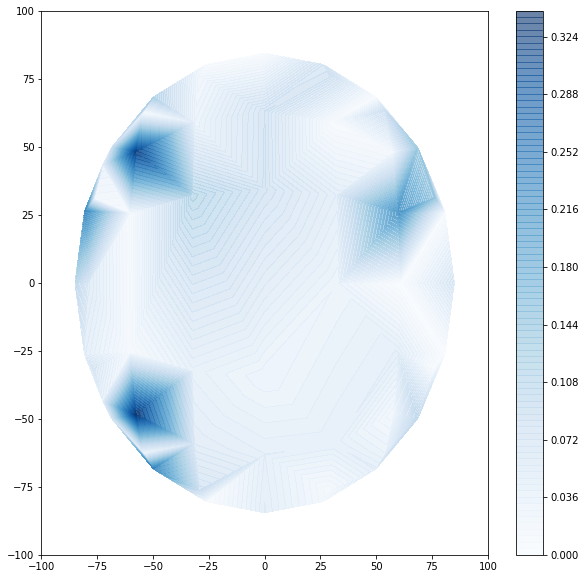

4


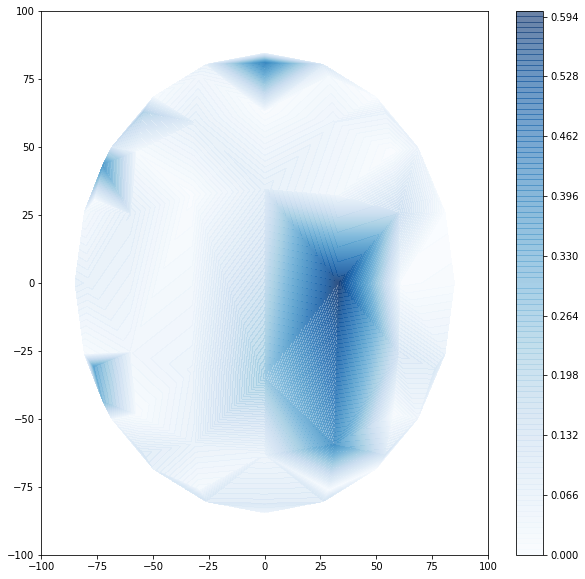

53


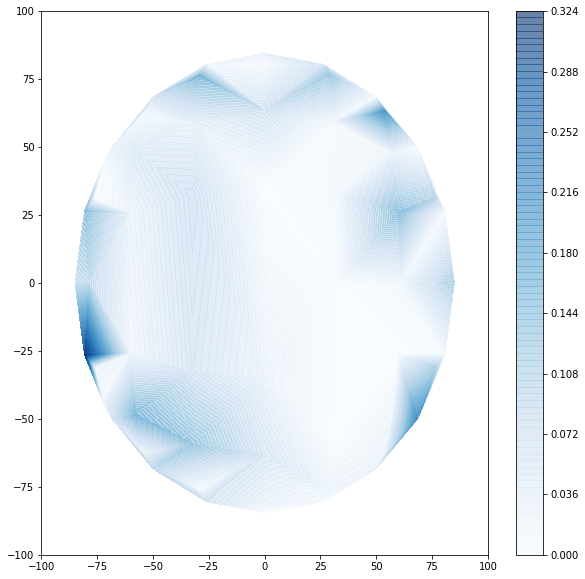

54


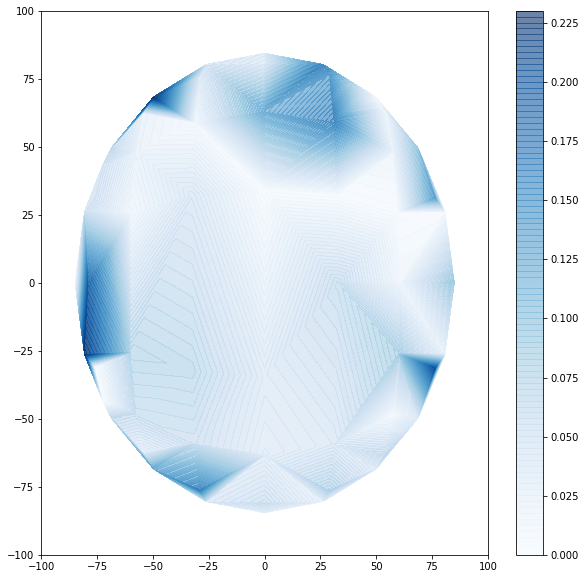

55


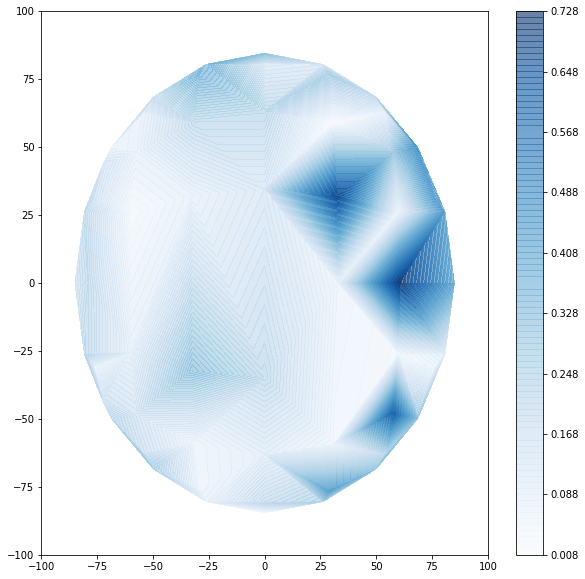

56


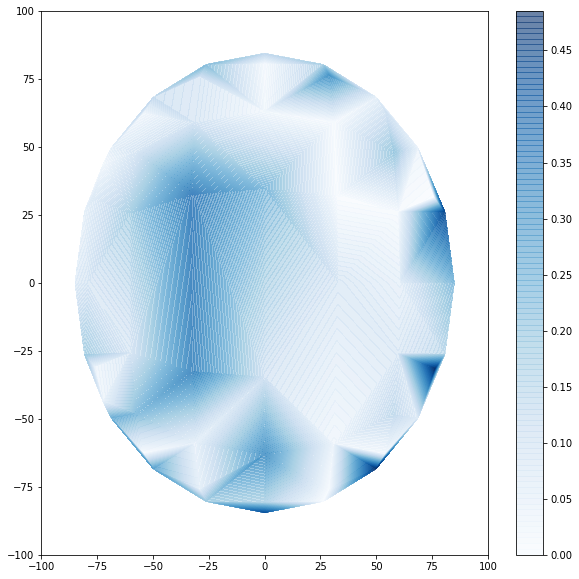

57


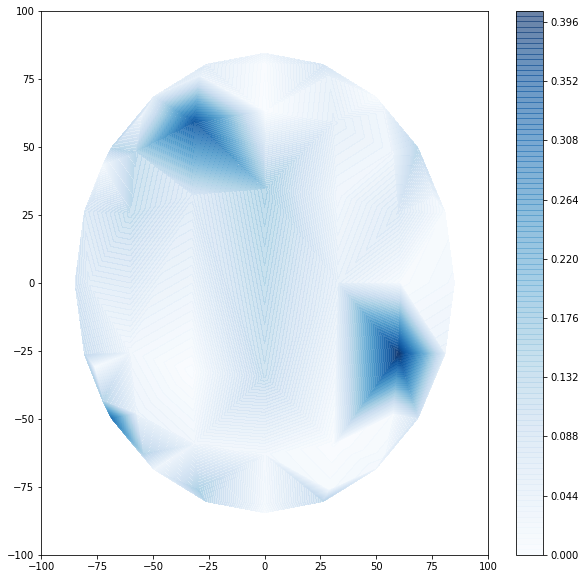

In [194]:
# The rows of the W matrix computed earlier maximise classwise variance based on the index of the row. 
# Initial few rows maximize controls class, last few rows maximize meditators class

# Iterate over initial rows and final rows of the W matrix
# The W matrix has n = 58 rows, (as there are 58 variables/electrodes)

def plot_contours():

    for i in [0,1,2,3,4,53,54,55,56,57]:

        # Print row number
        print(i)

        # Print heatmap of transformed values at electrode coordinates
        plt.figure(figsize = (10,10))
        plt.tricontourf(electrode_coordinates['001A'].drop(['Cz','Pz'])[0].values, # x coord
                        electrode_coordinates['001A'].drop(['Cz','Pz'])[1].values, # y coord
                    
                        np.abs(W[i,:]),100, # Matrix weight at row i
                        alpha = 0.6,cmap = 'Blues')

        plt.colorbar()
        plt.xlim(-100,100)
        plt.ylim(-100,100)
        plt.show()

plot_contours()

('001A', 'BL')


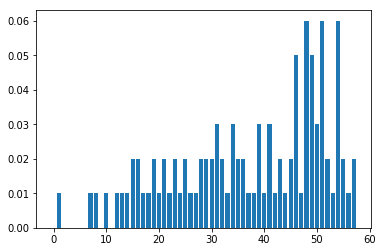

('002A', 'BL')


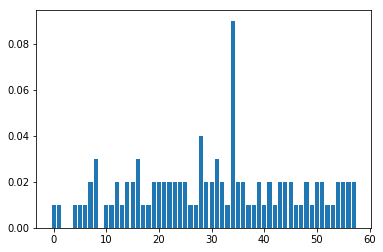

('006B', 'BL')


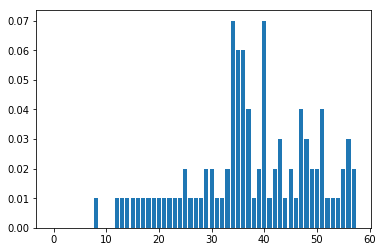

('008D', 'BL')


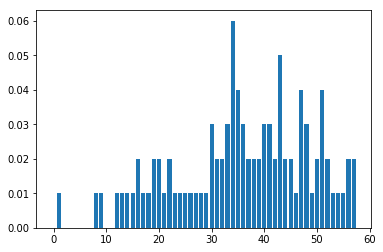

('009D', 'BL')


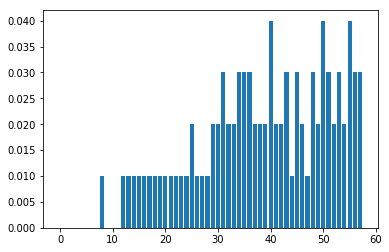

('015G', 'BL')


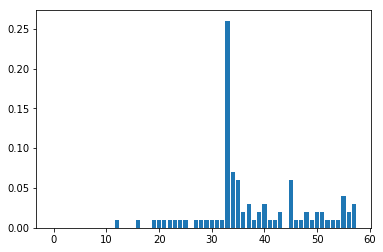

('016H', 'BL')


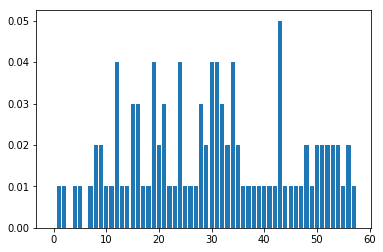

('017H', 'BL')


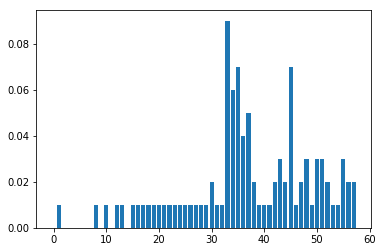

('018K', 'BL')


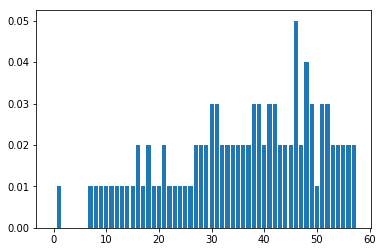

('020N', 'BL')


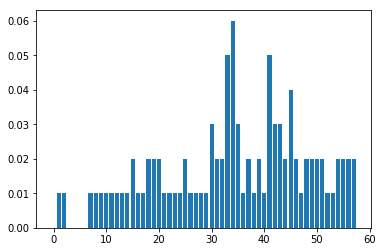

('023R', 'BL')


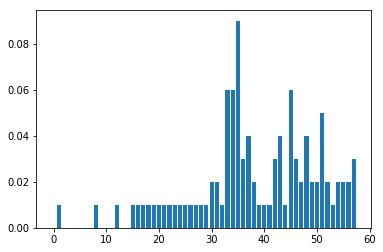

('024S', 'BL')


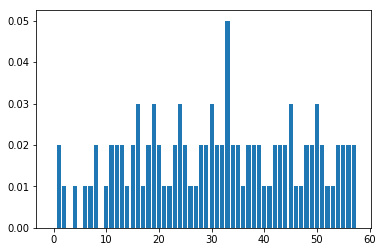

('025S', 'BL')


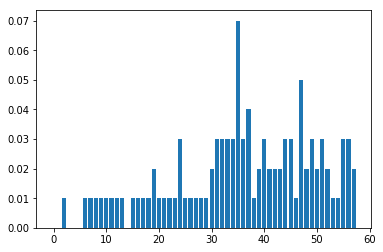

('026S', 'BL')


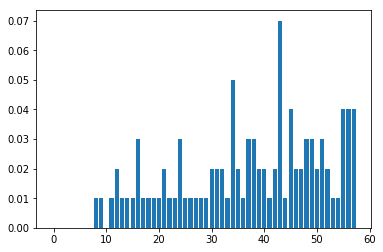

('C001', 'BL')


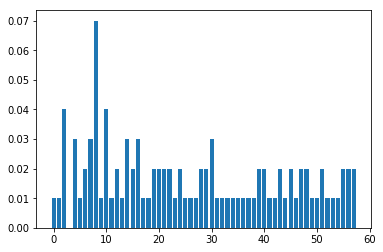

('C002', 'BL')


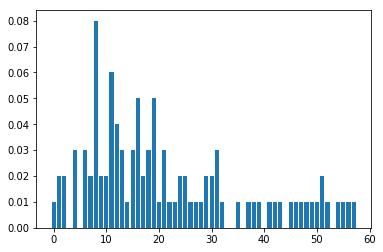

('C003', 'BL')


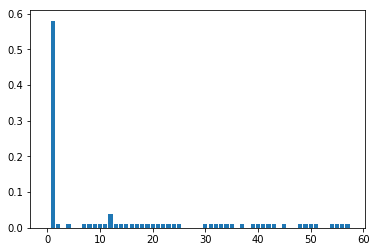

('C004', 'BL')


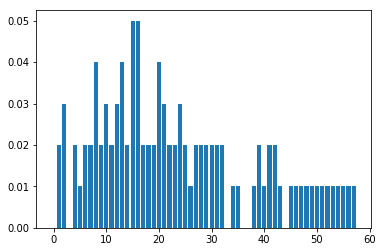

('C005', 'BL')


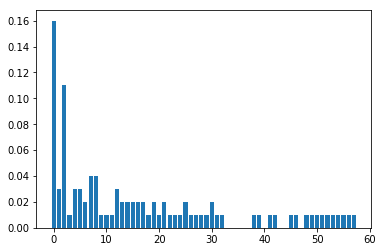

('C006', 'BL')


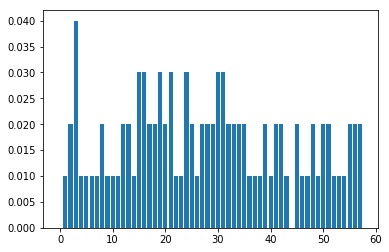

In [97]:
# We use this weighting matrix to transform the EEG data.
# The weighting matrix maximizes classwise variance for both classes. The initial rows maximize the controls class
# Final rows maximize meditators class
# We plot these variances for each subject as bar plots. Subjects starting with a number are meditators, subjects starting 
# with 'C00' are controls.

# Iterate over subject
for subject in EEG_data:
    
    print(subject)
    
    # x - axis -> range of electrodes(58)
    # y - axis -> transform raw data using W matrix, compute variance, normalize to obtain on a 0 to 1 scale
    
    plt.bar(np.arange(0,58),np.round(np.var(np.dot(W.T,EEG_data[subject]),axis = 1)/np.sum(np.var(np.dot(W.T,EEG_data[subject]),axis = 1)),2))
    plt.show()
    
# The variance is maximized in the latter part of the transformed variables for meditators and for the initial ones in controls
# as evidenced in the barplots.

# Visualizing Transformed Plots in 2-Dimensions

In [161]:
# Create data and label matrix, store as lists

X = []
y = []

# Iterate through subjects
for subject in EEG_data:
    
    ## Append epoch, use either EEGdataepoched or EEGlaplacianepoched
    
    # Iterate over epochs
    for epoch in range(0,EEG_data_epoched[subject].shape[0]):
        
        # Append the variance of the transformed data 
        X.append(np.var(np.dot(W.T,EEG_data_epoched[subject][epoch]),axis = 1))
    
    # Append the subject label
    y.append([subject[0][0]]*EEG_data_epoched[subject].shape[0])

In [162]:
# Use numpy's stack function to concatenate

X = np.vstack(X)
y = np.hstack(y)

In [166]:
# Encode the labels of y to a binary [0,1] representation

from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
y = le.fit_transform(y)

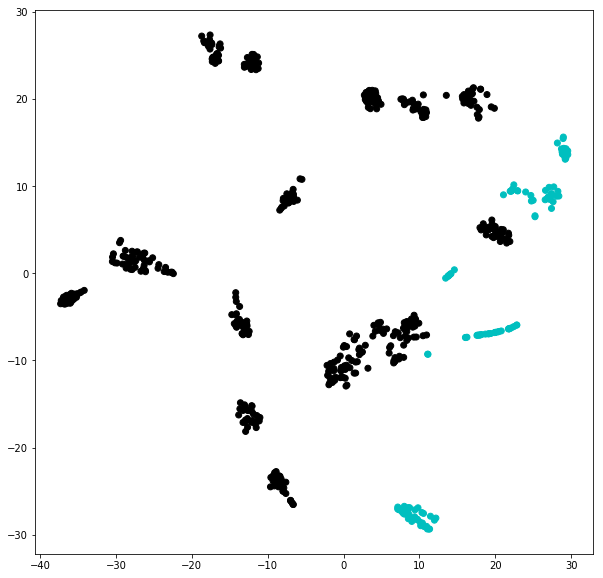

In [92]:
# Compute TSNE representation of the data X

from sklearn.manifold import TSNE
X_tsne = TSNE(n_components = 2).fit_transform(X)

# Plot the 2D TSNE representation colored using the labels

plt.figure(figsize = (10,10))
plt.scatter(X_tsne[:,0],X_tsne[:,1],c=y)